In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sentence_transformers import SentenceTransformer
from joblib import dump
from tqdm import tqdm

# === 1. Dosyayı oku
df = pd.read_csv("bigfive_train.csv")  # kendi dosya adını kullan
X_text = df["text"].astype(str).tolist()
y = df[["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]]

# === 2. Embedding çıkar (mBERT çok dilli)
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
X_emb = model.encode(X_text, show_progress_bar=True)

# === 3. Her bir özellik için regresyon eğit
columns = y.columns
for i, col in enumerate(columns):
    print(f"🎯 Eğitim: {col}")
    y_col = y[col]

    X_train, X_test, y_train, y_test = train_test_split(X_emb, y_col, test_size=0.2, random_state=42)

    reg = Ridge(alpha=1.0)  # ya da MLPRegressor, RandomForest vs.
    reg.fit(X_train, y_train)

    preds = reg.predict(X_test)
    score = r2_score(y_test, preds)
    print(f"✅ {col} R² Skoru: {score:.4f}")

    dump(reg, f"model_{col[:3].lower()}.joblib")  # model_opn.joblib, model_con.joblib, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

🎯 Eğitim: Openness
✅ Openness R² Skoru: 0.4248
🎯 Eğitim: Conscientiousness
✅ Conscientiousness R² Skoru: -0.5296
🎯 Eğitim: Extraversion
✅ Extraversion R² Skoru: 0.5254
🎯 Eğitim: Agreeableness
✅ Agreeableness R² Skoru: 0.3346
🎯 Eğitim: Neuroticism
✅ Neuroticism R² Skoru: -21.6713


In [17]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer
from joblib import load
from tqdm import tqdm

# === MODEL ve DOSYA YOLLARI
MODEL_DIR = r"C:\Users\enesk\OneDrive\Desktop\büyük veri"
DATA_DIR = os.path.join(MODEL_DIR, "etiketli_yorum_dosyaları")

models = {
    "Openness": load(os.path.join(MODEL_DIR, "model_opn.joblib")),
    "Conscientiousness": load(os.path.join(MODEL_DIR, "model_con.joblib")),
    "Extraversion": load(os.path.join(MODEL_DIR, "model_ext.joblib")),
    "Agreeableness": load(os.path.join(MODEL_DIR, "model_agr.joblib")),
    "Neuroticism": load(os.path.join(MODEL_DIR, "model_neu.joblib"))
}

embedder = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
csv_dosyalar = [f for f in os.listdir(DATA_DIR) if f.endswith(".csv")]

tum_sonuclar = []

for dosya in csv_dosyalar:
    print(f"\n🔍 İşleniyor: {dosya}")
    try:
        df = pd.read_csv(os.path.join(DATA_DIR, dosya), encoding="utf-8-sig", on_bad_lines="skip")
        if "review_text" not in df.columns:
            print("⛔ 'review_text' sütunu yok")
            continue

        yorumlar = df["review_text"].dropna().astype(str).tolist()
        if not yorumlar:
            print("⚠️ Yorum bulunamadı")
            continue

        # İlk 200 yorum ile sınırlı
        embeddings = embedder.encode(yorumlar, show_progress_bar=True)

        oyun_skorlar = {}
        for ozellik, model in models.items():
            preds = model.predict(embeddings)
            oyun_skorlar[ozellik] = round(preds.mean(), 4)

        oyun_skorlar["oyun"] = os.path.splitext(dosya)[0].replace("etiketli_", "").replace("_yorumlar", "").replace("_", " ")
        tum_sonuclar.append(oyun_skorlar)

    except Exception as e:
        print(f"❌ Hata ({dosya}): {e}")

# === SONUÇ CSV
if tum_sonuclar:
    sonuc_df = pd.DataFrame(tum_sonuclar)
    sonuc_df = sonuc_df[["oyun", "Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]]
    out_path = os.path.join(MODEL_DIR, "bigfive_tahmin_sonuclari.csv")
    sonuc_df.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"\n✅ Tahmin tamamlandı: {out_path}")
else:
    print("⚠️ Hiçbir dosya işlenemedi.")


🔍 İşleniyor: etiketli_Age_of_Empires_IV_Anniversary_Edition_yorumlar.csv


Batches:   0%|          | 0/209 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_ARK_yorumlar.csv


Batches:   0%|          | 0/191 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Balatro_yorumlar.csv


Batches:   0%|          | 0/242 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Baldurs_gate_3_yorumlar.csv


Batches:   0%|          | 0/237 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Battlefield_1_yorumlar.csv


Batches:   0%|          | 0/216 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Call_of_duty_Warzone_yorumlar.csv


Batches:   0%|          | 0/220 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Cities_Skylines_II_yorumlar.csv


Batches:   0%|          | 0/257 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Crusader_Kings_III_yorumlar.csv


Batches:   0%|          | 0/233 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_CS_2_yorumlar.csv


Batches:   0%|          | 0/176 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Cyberpunk_2077_yorumlar.csv


Batches:   0%|          | 0/225 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Dead_by_daylight_yorumlar.csv


Batches:   0%|          | 0/224 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Dead_cells_yorumlar.csv


Batches:   0%|          | 0/202 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_DOOM_eternal_yorumlar.csv


Batches:   0%|          | 0/252 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_EA_SPORTS_FC_25_yorumlar.csv


Batches:   0%|          | 0/205 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Elden_ring_yorumlar.csv


Batches:   0%|          | 0/221 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Escape_the_backrooms_yorumlar.csv


Batches:   0%|          | 0/195 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Europa_Universalis_IV_yorumlar.csv


Batches:   0%|          | 0/229 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Euro_Truck_Simulator_2_yorumlar.csv


Batches:   0%|          | 0/203 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Expedition_33_yorumlar.csv


Batches:   0%|          | 0/263 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_F1_24_yorumlar.csv


Batches:   0%|          | 0/216 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Football_Manager_2024_yorumlar.csv


Batches:   0%|          | 0/190 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Forza_Horizon_5_yorumlar.csv


Batches:   0%|          | 0/180 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_God_of_War_yorumlar.csv


Batches:   0%|          | 0/224 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_GTA_5_yorumlar.csv


Batches:   0%|          | 0/159 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Hades_yorumlar.csv


Batches:   0%|          | 0/229 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Loop_hero_yorumlar.csv


Batches:   0%|          | 0/251 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Mafia_definitive_edition_yorumlar.csv


Batches:   0%|          | 0/245 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Manor_lords_yorumlar.csv


Batches:   0%|          | 0/255 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_NBA_2K25_yorumlar.csv


Batches:   0%|          | 0/195 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Need_for_Speed_Unbound_yorumlar.csv


Batches:   0%|          | 0/243 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Outlast_yorumlar.csv


Batches:   0%|          | 0/247 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Phasmophobia_yorumlar.csv


Batches:   0%|          | 0/226 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Planet_zoo_yorumlar.csv


Batches:   0%|          | 0/235 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_PUBG_yorumlar.csv


Batches:   0%|          | 0/153 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_R.E.P.O_yorumlar.csv


Batches:   0%|          | 0/225 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Raft_yorumlar.csv


Batches:   0%|          | 0/180 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Rainbow_six_siege_yorumlar.csv


Batches:   0%|          | 0/216 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_RDR2_yorumlar.csv


Batches:   0%|          | 0/213 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Ready_or_Not_yorumlar.csv


Batches:   0%|          | 0/237 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Runied_king_yorumlar.csv


Batches:   0%|          | 0/261 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Rust_yorumlar.csv


Batches:   0%|          | 0/211 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_S.T.A.L.K.E.R._2_yorumlar.csv


Batches:   0%|          | 0/270 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Sid_Meier’s_Civilization_VI_yorumlar.csv


Batches:   0%|          | 0/196 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Slay_the_spire_yorumlar.csv


Batches:   0%|          | 0/186 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Stardew_Valley_yorumlar.csv


Batches:   0%|          | 0/200 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Street_Fighter_6_yorumlar.csv


Batches:   0%|          | 0/224 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Supermarket_simulator_yorumlar.csv


Batches:   0%|          | 0/241 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Team_Fortress_2_yorumlar.csv


Batches:   0%|          | 0/238 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_The Crew_2_yorumlar.csv


Batches:   0%|          | 0/214 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_The_forest_yorumlar.csv


Batches:   0%|          | 0/219 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_The_last_of_us_I_yorumlar.csv


Batches:   0%|          | 0/242 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_The_long_dark_yorumlar.csv


Batches:   0%|          | 0/253 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_The_Sims_4_yorumlar.csv


Batches:   0%|          | 0/224 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_The_Witcher_3_yorumlar.csv


Batches:   0%|          | 0/216 [00:00<?, ?it/s]


🔍 İşleniyor: etiketli_Total_War_WARHAMMER_II_yorumlar.csv


Batches:   0%|          | 0/223 [00:00<?, ?it/s]


✅ Tahmin tamamlandı: C:\Users\enesk\OneDrive\Desktop\büyük veri\bigfive_tahmin_sonuclari.csv


📊 Bar grafikler oluşturuldu.


C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\4237861424.py:45: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\4237861424.py:46: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.savefig("tum_oyunlar_radar.png", dpi=300)
C:\Users\enesk\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


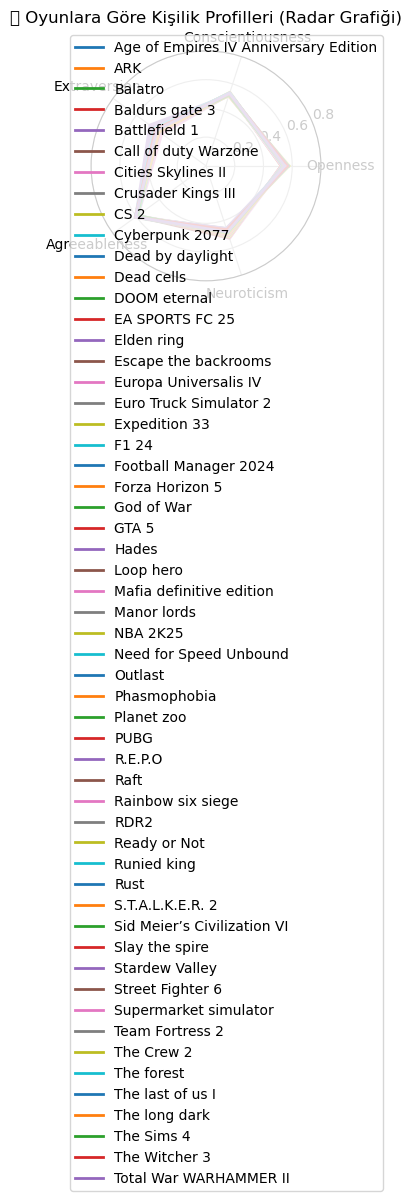

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Dosyayı yükle
df = pd.read_csv(r"C:\Users\enesk\OneDrive\Desktop\büyük veri\bigfive_tahmin_sonuclari.csv")

# === 1. BAR CHART – Oyun başına Big Five profili
for _, row in df.iterrows():
    oyun = row["oyun"]
    scores = row[["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]]
    
    plt.figure(figsize=(8, 4))
    scores.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(f"{oyun} – Big Five Kişilik Profili")
    plt.ylabel("Ortalama Skor")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{oyun.replace(' ', '_')}_bar.png", dpi=300)
    plt.close()

print("📊 Bar grafikler oluşturuldu.")

# === 2. RADAR CHART – Tüm oyunları aynı grafikte karşılaştır
def plot_radar_chart(df, oyunlar=None):
    traits = ["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]
    angles = np.linspace(0, 2 * np.pi, len(traits), endpoint=False).tolist()
    angles += angles[:1]  # kapanış için
    
    plt.figure(figsize=(8, 8))
    
    if oyunlar is None:
        oyunlar = df["oyun"].tolist()
    
    for _, row in df[df["oyun"].isin(oyunlar)].iterrows():
        values = row[traits].tolist()
        values += values[:1]
        plt.polar(angles, values, label=row["oyun"], linewidth=2)

    plt.xticks(angles[:-1], traits)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"])
    plt.title("🎯 Oyunlara Göre Kişilik Profilleri (Radar Grafiği)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.savefig("tum_oyunlar_radar.png", dpi=300)
    plt.show()

plot_radar_chart(df)

C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\2292464917.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti


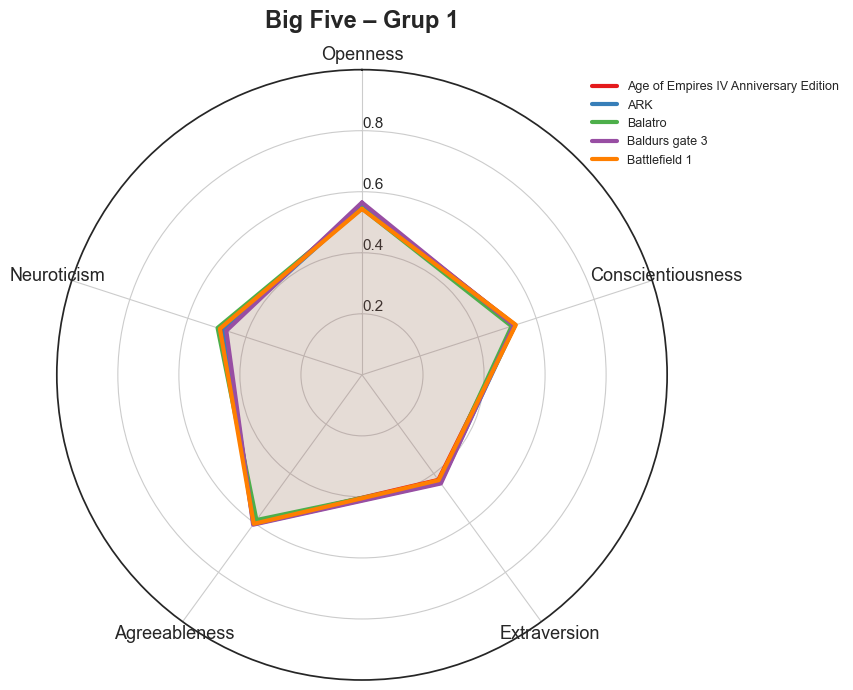

C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\2292464917.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti


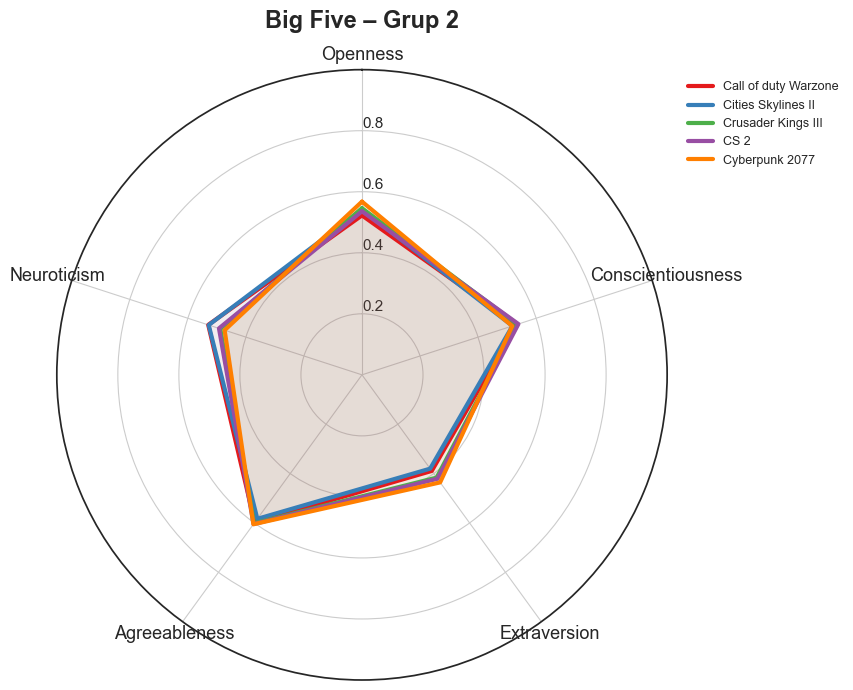

C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\2292464917.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti


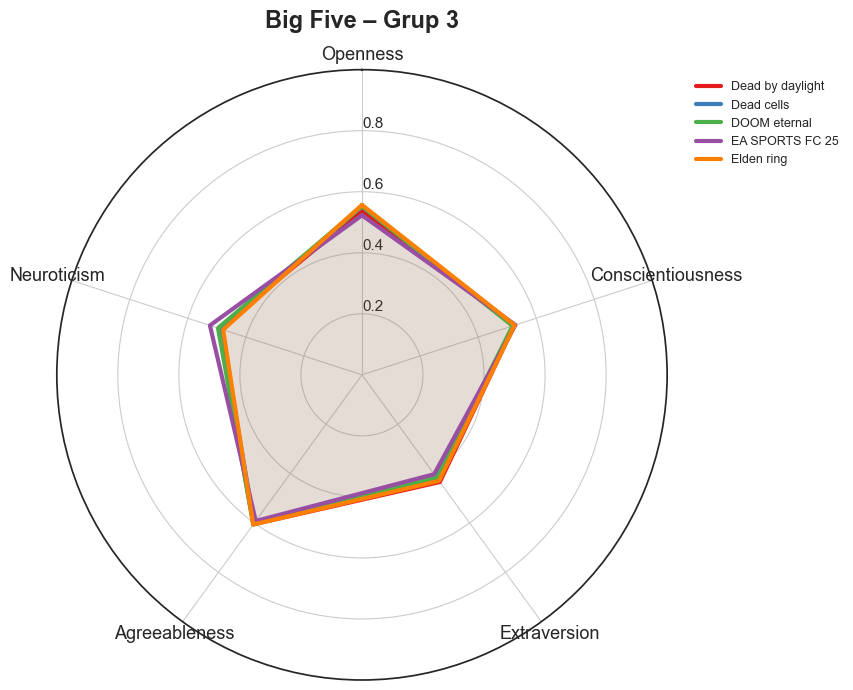

C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\2292464917.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti


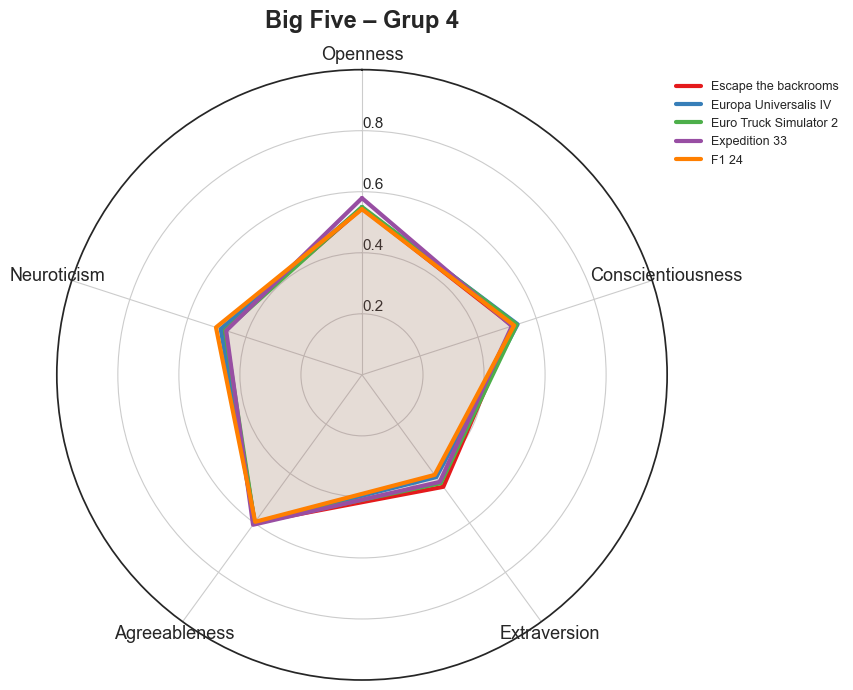

C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\2292464917.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti


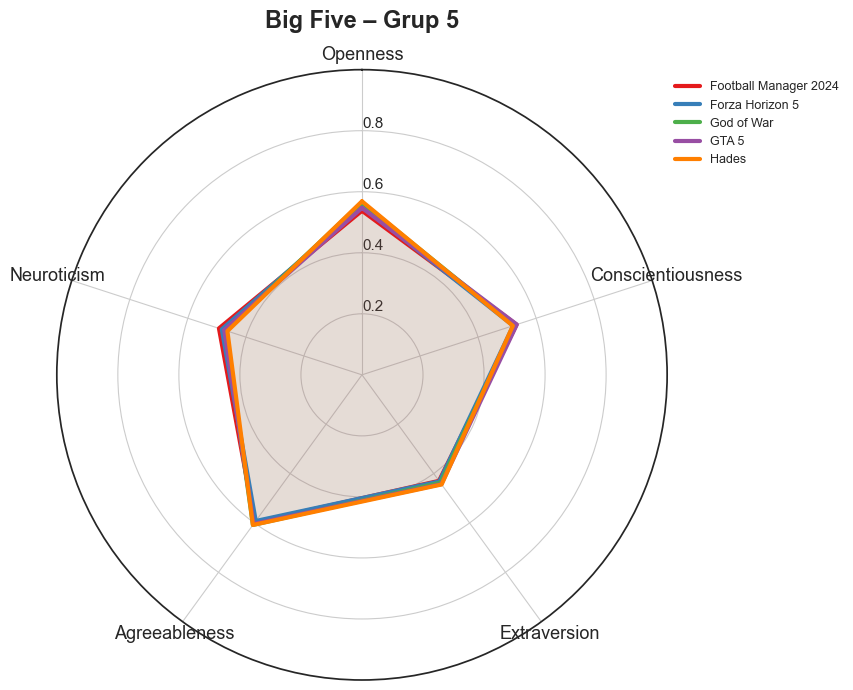

C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\2292464917.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti


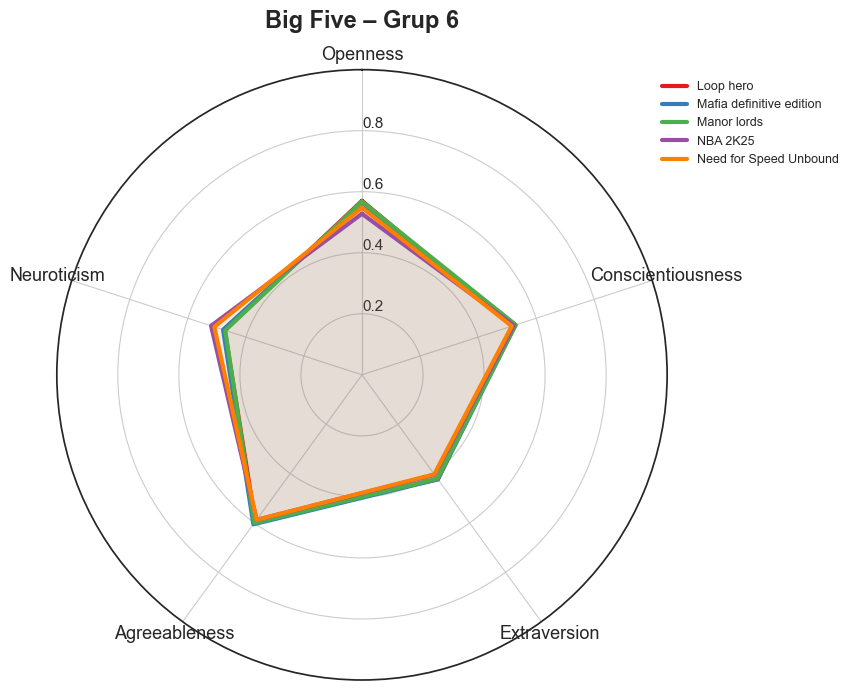

C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\2292464917.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti


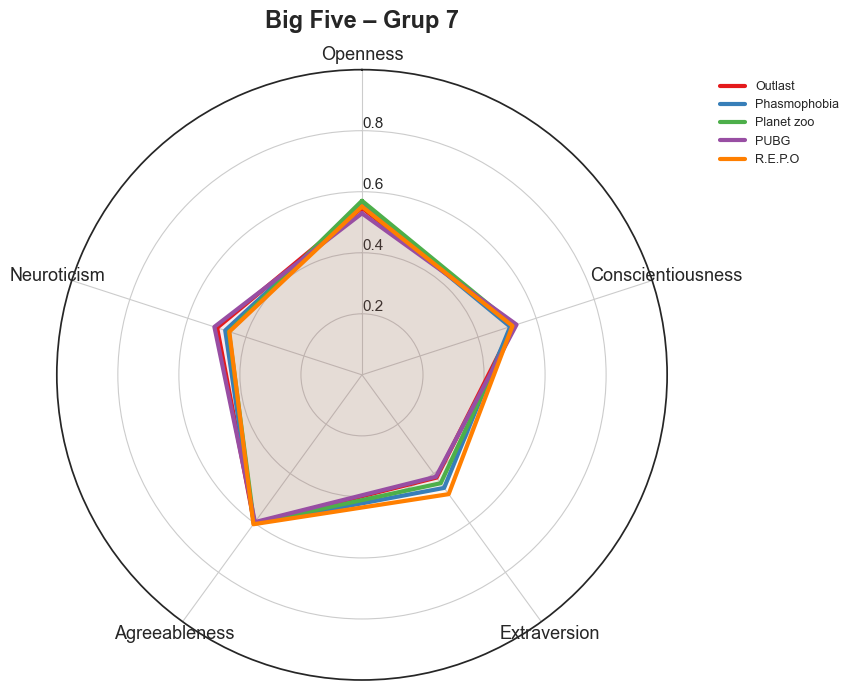

C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\2292464917.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti


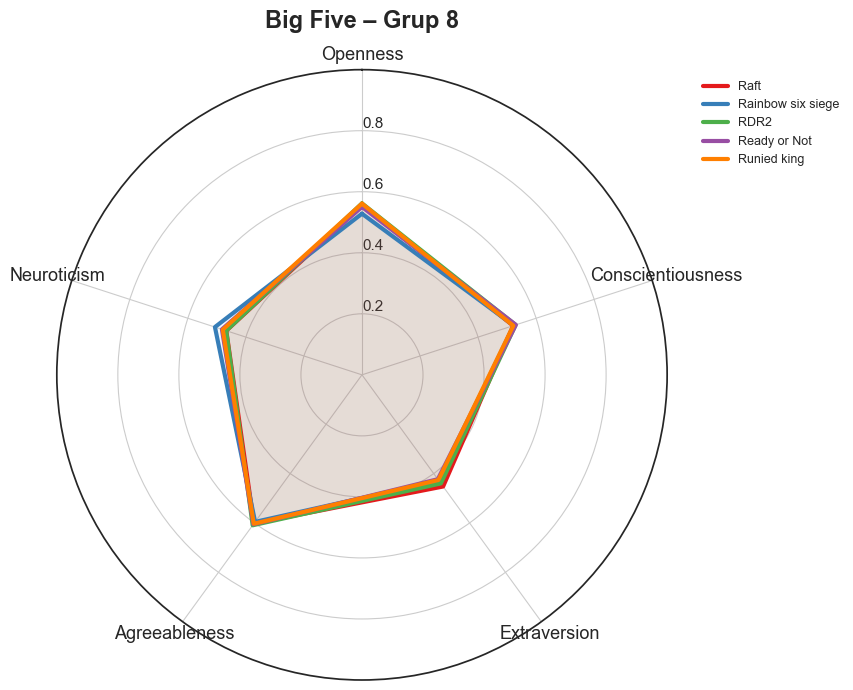

C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\2292464917.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti


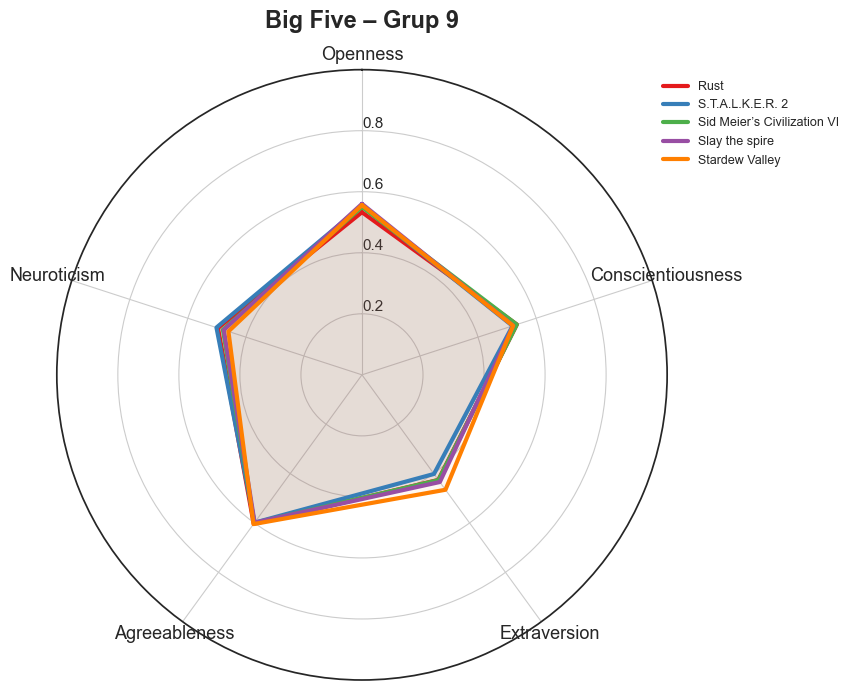

C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\2292464917.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti


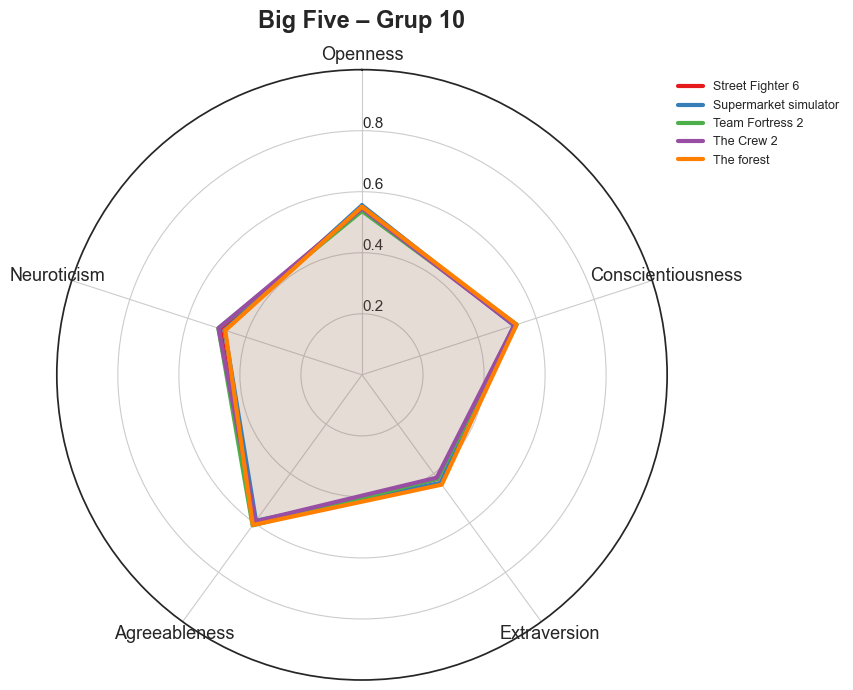

C:\Users\enesk\AppData\Local\Temp\ipykernel_29504\2292464917.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti


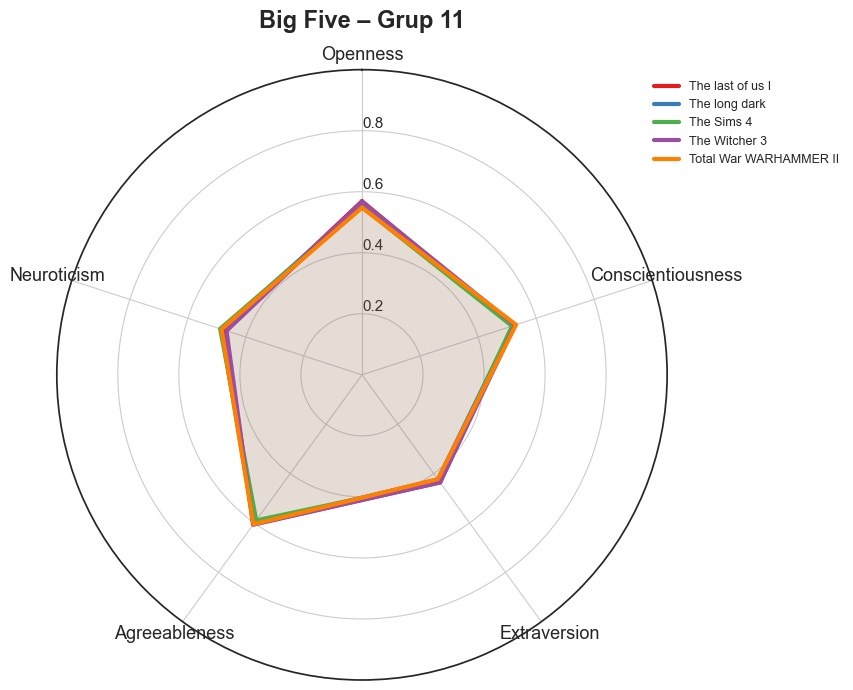

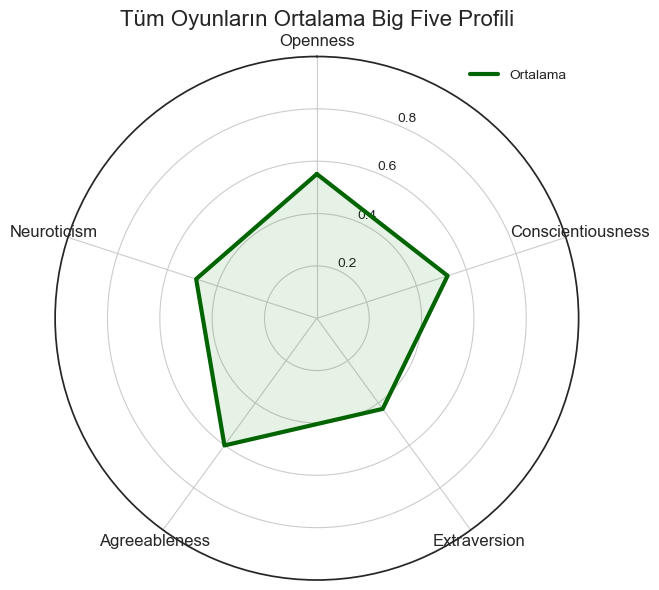

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.cm import get_cmap

# === 1. Dosyayı yükle
df = pd.read_csv(r"C:\Users\enesk\OneDrive\Desktop\büyük veri\bigfive_tahmin_sonuclari.csv")
traits = ["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]
angles = np.linspace(0, 2 * np.pi, len(traits), endpoint=False).tolist()
angles += angles[:1]

# === 2. Yeni radar çizim fonksiyonu (5 oyunluk grup)
def plot_radar_group(df, group_id, oyunlar, save=True):
    plt.figure(figsize=(9, 7))
    ax = plt.subplot(111, polar=True)
    plt.style.use("seaborn-v0_8-white")

    cmap = get_cmap("Set1")  # Daha kontrastlı renk paleti
    for i, oyun in enumerate(oyunlar):
        row = df[df["oyun"] == oyun]
        if row.empty:
            continue
        values = row[traits].values.flatten().tolist()
        values += values[:1]
        color = cmap(i % cmap.N)

        ax.plot(angles, values, label=oyun, linewidth=3, color=color)
        ax.fill(angles, values, alpha=0.05, color=color)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(traits, fontsize=13)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], fontsize=11)
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(0)

    plt.title(f"Big Five – Grup {group_id+1}", fontsize=17, pad=30, weight="bold")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize=9)
    plt.tight_layout()
    if save:
        plt.savefig(f"radar_grup_{group_id+1}_ayik.png", dpi=300)
    plt.show()

# === 3. 5'erli gruplara ayır
oyunlar = df["oyun"].tolist()
group_size = 5
group_count = math.ceil(len(oyunlar) / group_size)

for i in range(group_count):
    oyun_grubu = oyunlar[i * group_size : (i + 1) * group_size]
    plot_radar_group(df, i, oyun_grubu)

# === 4. ORTALAMA GRAFİK
ortalama = df[traits].mean().tolist() + [df[traits].mean().tolist()[0]]
plt.figure(figsize=(8, 6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, ortalama, color="darkgreen", linewidth=3, label="Ortalama")
ax.fill(angles, ortalama, alpha=0.1, color="green")
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(traits, fontsize=12)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_ylim(0, 1)
plt.title("Tüm Oyunların Ortalama Big Five Profili", fontsize=16)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("ortalama_okunakli_radar.png", dpi=300)
plt.show()